In [ ]:
!pip install tensorflow
!pip install scikit-learn
!pip install torch torchvision
!pip install torch-geometric
!pip install optuna
!pip install scikit-learn
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install timm
# # or for huggingface transformers if you'd like to use that:
!pip install transformers
!pip install scikit-learn
!pip install matplotlib opencv-python
!pip install tensorflow
!pip install keras-tuner

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sivm205/soybean-diseased-leaf-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/soybean-diseased-leaf-dataset


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Import PyTorch Geometric modules
from torch_geometric.nn import GCNConv, global_mean_pool

import optuna


In [4]:
import tensorflow as tf
import tensorflow.keras.layers as layers
import numpy as np
import networkx as nx
import scipy.sparse as sp
import os
import cv2
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import optuna
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Dataset Directory
dataset_dir = "/kaggle/input/soybean-diseased-leaf-dataset"

# Load dataset images and labels
def load_dataset(dataset_dir, img_size=(224, 224)):
    images = []
    labels = []
    class_names = sorted(os.listdir(dataset_dir))
    class_dict = {class_name: idx for idx, class_name in enumerate(class_names)}
    
    for class_name in class_names:
        class_path = os.path.join(dataset_dir, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize image
            images.append(img)
            labels.append(class_dict[class_name])
    
    return np.array(images), np.array(labels)

# Load actual dataset
images, labels = load_dataset(dataset_dir)

# Data Preprocessing & Augmentation
def preprocess_data(X, y):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        rescale=1./255
    )
    return datagen.flow(X, y, batch_size=32)

# Load MobileNetV2 as feature extractor
def create_cnn(input_shape):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(128, activation='relu')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

# Extract features from images using MobileNetV2
def extract_features(images):
    cnn_model = create_cnn((224, 224, 3))
    batch_size = 16  # Reduce batch size to prevent memory overflow
    return cnn_model.predict(images, batch_size=batch_size)

# Construct graph using cosine similarity of image features
def create_graph(image_features, threshold=0.8):
    similarity_matrix = cosine_similarity(image_features)
    adj_matrix = (similarity_matrix > threshold).astype(int)
    return sp.coo_matrix(adj_matrix)

# Graph Convolutional Network (GCN) Layer
def create_gcn(adj_matrix, features):
    input_features = tf.keras.Input(shape=(features.shape[1],))
    x = layers.Dense(64, activation='relu')(input_features)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(10, activation='softmax')(x)  # Output layer for classification
    return tf.keras.Model(inputs=input_features, outputs=outputs)

# Sequential CNN-GCN Model
def create_sequential_cnn_gnn(input_shape, adj_matrix):
    cnn_model = create_cnn(input_shape)
      # Free up GPU memory
    cnn_output = cnn_model.output  # CNN extracts features first
    
    # Generate adjacency matrix and pass features to GCN
    
    gcn_model = create_gcn(adj_matrix, node_features)
    
    model = tf.keras.Model(inputs=cnn_model.input, outputs=gcn_model(cnn_output))
    return model

# Extract features and create graph
node_features = extract_features(images)
adj_matrix = create_graph(node_features)

# Train-Test Split
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Create and compile the model
sequential_model = create_sequential_cnn_gnn((224, 224, 3), adj_matrix)
sequential_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
sequential_model.fit(train_data, tf.keras.utils.to_categorical(train_labels, num_classes=10), epochs=20, batch_size=32, validation_data=(test_data, tf.keras.utils.to_categorical(test_labels, num_classes=10)))

# Evaluate the model
def evaluate_model(model, test_data, test_labels):
    test_labels = np.argmax(test_labels, axis=1)  # Convert one-hot encoding to categorical labels
    predictions = model.predict(test_data)
    predicted_labels = np.argmax(predictions, axis=1)
    
    acc = accuracy_score(test_labels, predicted_labels)
    precision = precision_score(test_labels, predicted_labels, average='weighted')
    recall = recall_score(test_labels, predicted_labels, average='weighted')
    f1 = f1_score(test_labels, predicted_labels, average='weighted')
    
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    return acc, precision, recall, f1

# Evaluate and save the model
evaluate_model(sequential_model, test_data, tf.keras.utils.to_categorical(test_labels, num_classes=10))
sequential_model.save('sequential_cnn_gnn.h5')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step
Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 532ms/step - accuracy: 0.4456 - loss: 1.6961 - val_accuracy: 0.9362 - val_loss: 0.4386
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8915 - loss: 0.3444 - val_accuracy: 0.8865 - val_loss: 0.3354
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9288 - loss: 0.2169 - val_accuracy: 0.9433 - val_loss: 0.1684
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9551 - loss: 0.1404 - val_accuracy: 0.9574 - val_loss: 0.1476
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9723 - loss: 0.0711 - val_accuracy: 0.9645 - val_loss: 0.1270
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9896 - loss: 0.0419 - val_accuracy: 0.9716 - val_loss: 0.1209
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9998 - loss: 0.0286 - val_accuracy: 0.9645 - val_loss: 0.1420
Epoch 8/20
18/18 ━━

# Apply Grad-CAM

# Multiple

input_layer_2
Conv1
bn_Conv1
Conv1_relu
expanded_conv_depthwise
expanded_conv_depthwise_BN
expanded_conv_depthwise_relu
expanded_conv_project
expanded_conv_project_BN
block_1_expand
block_1_expand_BN
block_1_expand_relu
block_1_pad
block_1_depthwise
block_1_depthwise_BN
block_1_depthwise_relu
block_1_project
block_1_project_BN
block_2_expand
block_2_expand_BN
block_2_expand_relu
block_2_depthwise
block_2_depthwise_BN
block_2_depthwise_relu
block_2_project
block_2_project_BN
block_2_add
block_3_expand
block_3_expand_BN
block_3_expand_relu
block_3_pad
block_3_depthwise
block_3_depthwise_BN
block_3_depthwise_relu
block_3_project
block_3_project_BN
block_4_expand
block_4_expand_BN
block_4_expand_relu
block_4_depthwise
block_4_depthwise_BN
block_4_depthwise_relu
block_4_project
block_4_project_BN
block_4_add
block_5_expand
block_5_expand_BN
block_5_expand_relu
block_5_depthwise
block_5_depthwise_BN
block_5_depthwise_relu
block_5_project
block_5_project_BN
block_5_add
block_6_expand
block_6_

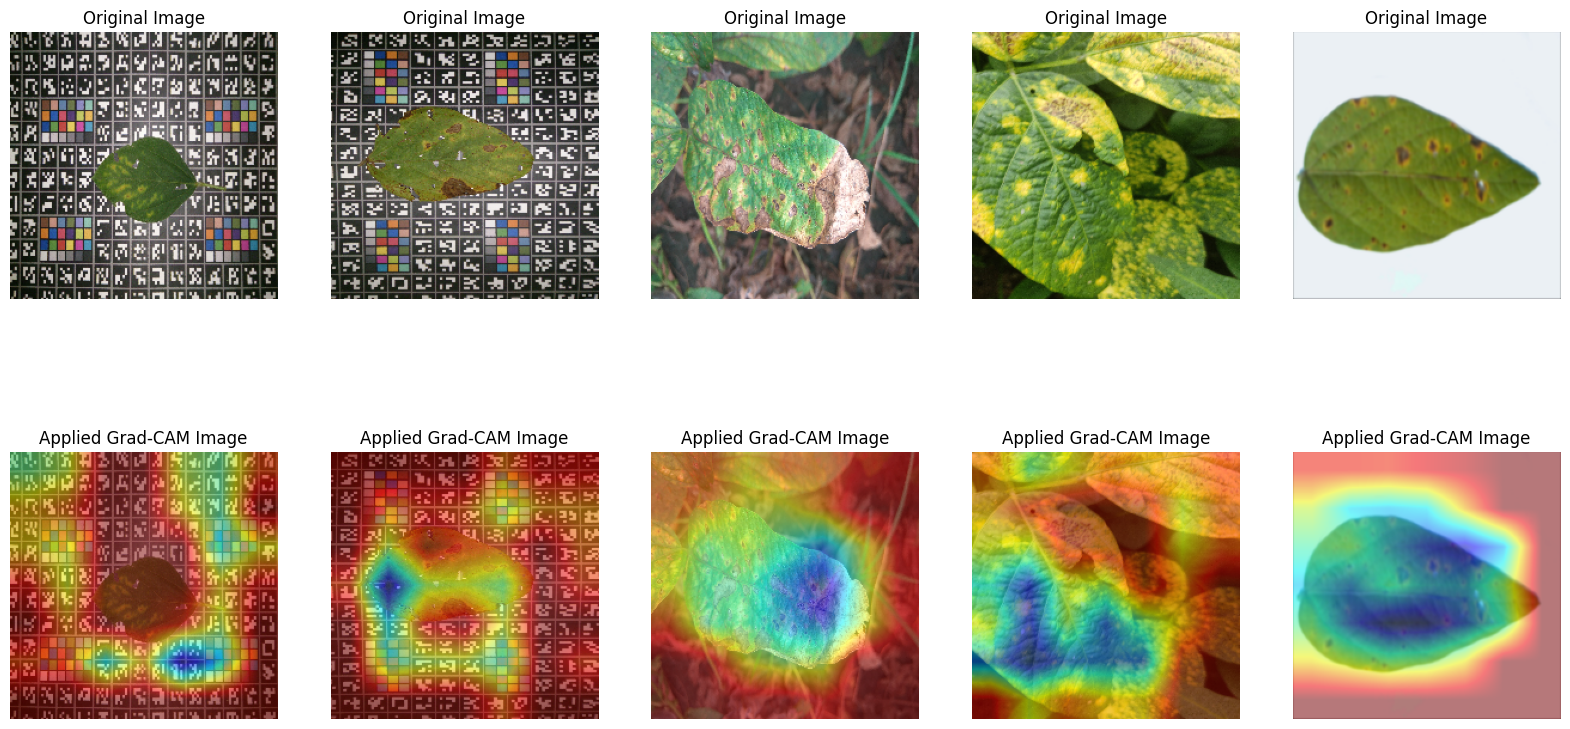

Saved Grad-CAM results as gradcam_output1.jpg


In [13]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load your trained model
model = load_model("/kaggle/input/model/other/default/1/sequential_cnn_gnn (1).h5")

# Extract MobileNetV2 (CNN Part) from Sequential Model
cnn_part = model.get_layer("mobilenetv2_1.00_224")
for layer in cnn_part.layers:
    print(layer.name)  # Identify actual last conv layer

cnn_model = tf.keras.Model(inputs=cnn_part.input, outputs=cnn_part.get_layer("Conv_1").output)

# Function to preprocess input image
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize if needed
    return tf.convert_to_tensor(img_array, dtype=tf.float32)  # Ensure Tensor format

# Function to generate Grad-CAM heatmap for CNN layers before GNN
def grad_cam(model, img_array):
    img_array = tf.convert_to_tensor(img_array, dtype=tf.float32)  # Ensure tensor format
    with tf.GradientTape() as tape:
        tape.watch(img_array)  # Ensure proper gradient computation
        conv_outputs = model(img_array)
        output = tf.reduce_mean(conv_outputs, axis=(1, 2))  # Global Average Pooling
        loss = tf.reduce_mean(output)
    
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    conv_outputs = conv_outputs.numpy()
    grads = grads.numpy()
    pooled_grads = pooled_grads.numpy()
    
    for i in range(pooled_grads.shape[-1]):
        conv_outputs[0, :, :, i] *= pooled_grads[i]
    
    heatmap = np.mean(conv_outputs[0], axis=-1)
    heatmap = np.maximum(heatmap, 0)  # ReLU
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1  # Avoid division by zero
    return heatmap

# Function to overlay heatmap on image
def overlay_heatmap(img_path, heatmap, target_size=(224, 224), alpha=0.5):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)  # Resize image to ensure uniform size
    heatmap = cv2.resize(heatmap, target_size)  # Resize heatmap to match image
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    overlay = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    return overlay

# Function to process multiple images and save them in a 2-row figure
def process_multiple_images(image_paths, target_size=(224, 224), save_path="gradcam_output1.jpg"):
    fig, axes = plt.subplots(2, len(image_paths), figsize=(20, 10))  # 2 rows, 5 columns
    
    for i, img_path in enumerate(image_paths):
        original_img = cv2.imread(img_path)
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
        original_img = cv2.resize(original_img, target_size)
        
        processed_img = preprocess_image(img_path, target_size)
        heatmap = grad_cam(cnn_model, processed_img)
        overlay = overlay_heatmap(img_path, heatmap, target_size)
        
        # Display original image in upper row
        axes[0, i].imshow(original_img)
        axes[0, i].axis("off")
        axes[0, i].set_title("Original Image")
        
        # Display Grad-CAM applied image in lower row
        axes[1, i].imshow(overlay)
        axes[1, i].axis("off")
        axes[1, i].set_title("Applied Grad-CAM Image")
    
    plt.savefig(save_path, format='jpg', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved Grad-CAM results as {save_path}")

# Example Usage
image_paths = [
    "/kaggle/input/soybean-diseased-leaf-dataset/Mossaic Virus/DSC_0114.jpg",
    "/kaggle/input/soybean-diseased-leaf-dataset/Southern blight/DSC_0023.jpg",
    "/kaggle/input/soybean-diseased-leaf-dataset/Sudden Death Syndrone/Sudden DS (1).jpg",
    "/kaggle/input/soybean-diseased-leaf-dataset/Yellow Mosaic/YM (1).jpg",
    "/kaggle/input/soybean-diseased-leaf-dataset/bacterial_blight/bb (1).bmp"
]

process_multiple_images(image_paths, save_path="gradcam_output1.jpg")

# Eigen-CAM

input_layer_2
Conv1
bn_Conv1
Conv1_relu
expanded_conv_depthwise
expanded_conv_depthwise_BN
expanded_conv_depthwise_relu
expanded_conv_project
expanded_conv_project_BN
block_1_expand
block_1_expand_BN
block_1_expand_relu
block_1_pad
block_1_depthwise
block_1_depthwise_BN
block_1_depthwise_relu
block_1_project
block_1_project_BN
block_2_expand
block_2_expand_BN
block_2_expand_relu
block_2_depthwise
block_2_depthwise_BN
block_2_depthwise_relu
block_2_project
block_2_project_BN
block_2_add
block_3_expand
block_3_expand_BN
block_3_expand_relu
block_3_pad
block_3_depthwise
block_3_depthwise_BN
block_3_depthwise_relu
block_3_project
block_3_project_BN
block_4_expand
block_4_expand_BN
block_4_expand_relu
block_4_depthwise
block_4_depthwise_BN
block_4_depthwise_relu
block_4_project
block_4_project_BN
block_4_add
block_5_expand
block_5_expand_BN
block_5_expand_relu
block_5_depthwise
block_5_depthwise_BN
block_5_depthwise_relu
block_5_project
block_5_project_BN
block_5_add
block_6_expand
block_6_

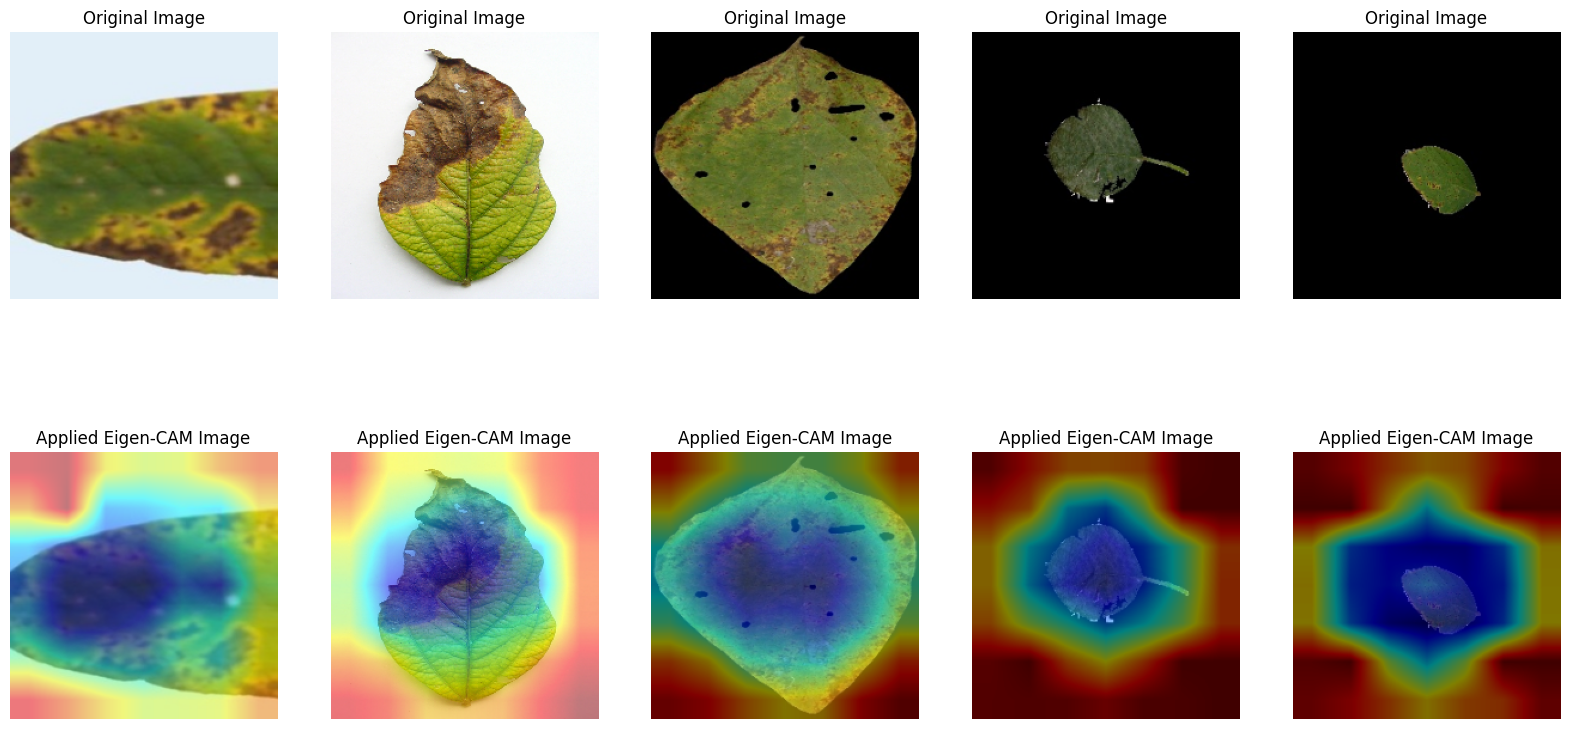

Saved Eigen-CAM results as eigen_cam_output1.jpg


In [16]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load your trained model
model = load_model("/kaggle/input/model/other/default/1/sequential_cnn_gnn (1).h5")

# Extract MobileNetV2 (CNN Part) from Sequential Model
cnn_part = model.get_layer("mobilenetv2_1.00_224")
for layer in cnn_part.layers:
    print(layer.name)  # Identify actual last conv layer

cnn_model = tf.keras.Model(inputs=cnn_part.input, outputs=cnn_part.get_layer("Conv_1").output)

# Function to preprocess input image
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize if needed
    return tf.convert_to_tensor(img_array, dtype=tf.float32)  # Ensure Tensor format

# Function to generate Eigen-CAM heatmap
def eigen_cam(model, img_array):
    conv_outputs = model(img_array)
    conv_outputs = conv_outputs.numpy()[0]
    reshaped_outputs = conv_outputs.reshape((-1, conv_outputs.shape[-1]))
    mean_feature = np.mean(reshaped_outputs, axis=0)
    heatmap = np.dot(conv_outputs, mean_feature)
    
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1
    return heatmap

# Function to overlay heatmap on image
def overlay_heatmap(img_path, heatmap, target_size=(224, 224), alpha=0.5):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)  # Resize image to ensure uniform size
    heatmap = cv2.resize(heatmap, target_size)  # Resize heatmap to match image
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    overlay = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    return overlay

# Function to process multiple images and save them in a 2-row figure
def process_multiple_images(image_paths, target_size=(224, 224), save_path="eigen_cam_output1.jpg"):
    fig, axes = plt.subplots(2, len(image_paths), figsize=(20, 10))  # 2 rows, 5 columns
    
    for i, img_path in enumerate(image_paths):
        original_img = cv2.imread(img_path)
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
        original_img = cv2.resize(original_img, target_size)
        
        processed_img = preprocess_image(img_path, target_size)
        heatmap = eigen_cam(cnn_model, processed_img)
        overlay = overlay_heatmap(img_path, heatmap, target_size)
        
        # Display original image in upper row
        axes[0, i].imshow(original_img)
        axes[0, i].axis("off")
        axes[0, i].set_title("Original Image")
        
        # Display Eigen-CAM applied image in lower row
        axes[1, i].imshow(overlay)
        axes[1, i].axis("off")
        axes[1, i].set_title("Applied Eigen-CAM Image")
    
    plt.savefig(save_path, format='jpg', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved Eigen-CAM results as {save_path}")

# Example Usage
image_paths = [
    "/kaggle/input/soybean-diseased-leaf-dataset/brown_spot/bs (10).JPG",
    "/kaggle/input/soybean-diseased-leaf-dataset/crestamento/3.JPG",
    "/kaggle/input/soybean-diseased-leaf-dataset/ferrugen/DSC_0009.jpg",
    "/kaggle/input/soybean-diseased-leaf-dataset/powdery_mildew/DSC_0059.jpg",
    "/kaggle/input/soybean-diseased-leaf-dataset/septoria/DSC_0080.jpg"
]

process_multiple_images(image_paths, save_path="eigen_cam_output1.jpg")


# Benchmarking table

In [15]:
import pandas as pd

# Data for benchmarking
benchmark_data = {
    "Model": [
        "CNN", "GNN", "Sequential CNN+GNN", "Sequential GNN+CNN", 
        "Parallel CNN+GNN", "SVC", "RandomForest", "LogisticRegression", "KNN"
    ],
    "Accuracy": [0.9275, 0.9130, 0.9645, 0.9645, 0.9574, 0.7705, 0.7705, 0.7705, 0.6639],
    "Precision": [0.9048, 0.9076, 0.9707, 0.9707, 0.9636, 0.7600, 0.7486, 0.7339, 0.7000],
    "Recall": [0.8903, 0.9130, 0.9645, 0.9645, 0.9574, 0.7705, 0.7705, 0.7705, 0.6639],
    "F1 Score": [0.8948, 0.9022, 0.9614, 0.9567, 0.9496, 0.7365, 0.7365, 0.7442, 0.6121]
}

# Creating DataFrame
benchmark_df = pd.DataFrame(benchmark_data)

from IPython.display import display
display(benchmark_df)

,Model,Accuracy,Precision,Recall,F1 Score
0,CNN,0.9275,0.9048,0.8903,0.8948
1,GNN,0.9130,0.9076,0.9130,0.9022
2,Sequential CNN+GNN,0.9645,0.9707,0.9645,0.9614
3,Sequential GNN+CNN,0.9645,0.9707,0.9645,0.9567
4,Parallel CNN+GNN,0.9574,0.9636,0.9574,0.9496
5,SVC,0.7705,0.7600,0.7705,0.7365
6,RandomForest,0.7705,0.7486,0.7705,0.7365
7,LogisticRegression,0.7705,0.7339,0.7705,0.7442
8,KNN,0.6639,0.7000,0.6639,0.6121
